# Cost Comparison

The cost of each model run is calculated with `COST_FUNCTION.ipynb`. Here we plot multiple costs to compare across runs.

The only required inputs for this script are the NetCDF files that contain the summary and cost of each model run. And maybe the list of parameters names and descriptions if you hope to extract parameter values from the cost file. The parameter list on Abby's computer is stored here: `'/Users/akbaskind/Desktop/ROMS_Code_Feb2025/ParameterList.csv'` but it can be downloaded [here](https://drive.google.com/file/d/1AIEgbwP2xlQS91wapm3UyyrvOb8HyInu/view?usp=drive_link).



In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math


# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns
import pyleoclim as pyleo
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

# Open cost files

As of 26/6/2025, the only real cost file we have is `CTRL2005.nc`. We will use a dummy cost file `CTRL5_2005.nc` as a placeholder.

In [2]:
PATH = '/Users/akbaskind/Desktop/COST_FILES/CTRL2005.nc'
ctrl2005 = xr.open_mfdataset(PATH)

PATH = '/Users/akbaskind/Desktop/COST_FILES/CTRL5_2005.nc'
dummy = xr.open_mfdataset(PATH)

# Plot multiple costs

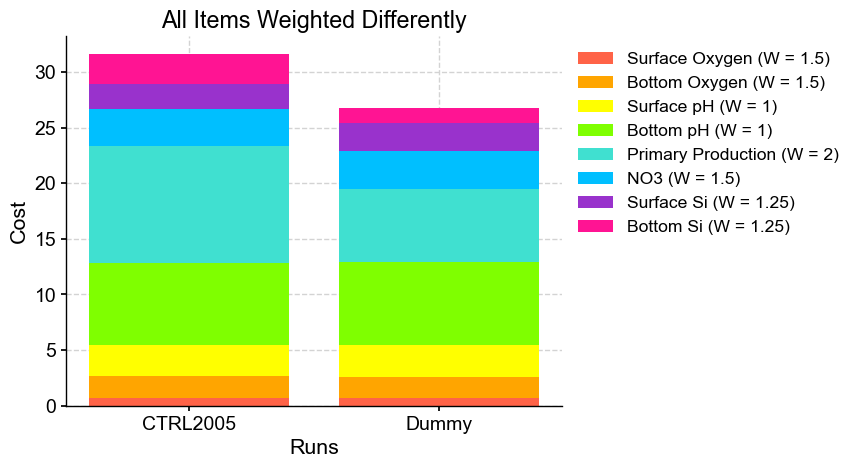

In [3]:
runs = ['CTRL2005', 'Dummy']
DOs = [1.5**2 * ctrl2005['oxygen_cost'][0], 1.5**2 * dummy['oxygen_cost'][0]]
DOb = [1.5**2 * ctrl2005['oxygen_cost'][1], 1.5**2 * dummy['oxygen_cost'][1]]
pHs = [ctrl2005['pH_cost'][0], dummy['pH_cost'][0]]
pHb = [ctrl2005['pH_cost'][1], dummy['pH_cost'][1]]
PPcost = [2**2 * ctrl2005['PP_cost'], 2**2 * dummy['PP_cost']]
NO3cost = [1.5**2 * ctrl2005['NO3_cost'], 1.5**2 * dummy['NO3_cost']]
Sis = [1.25**2 * ctrl2005['Si_cost'][0], 1.25**2 * dummy['Si_cost'][0]]
Sib = [1.25**2 * ctrl2005['Si_cost'][1], 1.25**2 * dummy['Si_cost'][1]]


# Create the bar chart
fig, ax = plt.subplots()

# Plot the first group of bars
ax.bar(runs, np.array(DOs), label='Surface Oxygen (W = 1.5)', color = 'tomato')
ax.bar(runs, np.array(DOb), bottom=np.array(DOs), label='Bottom Oxygen (W = 1.5)', color = 'orange')
ax.bar(runs, np.array(pHs), bottom= (np.array(DOs) + np.array(DOb)), label='Surface pH (W = 1)', color = 'yellow')
ax.bar(runs, np.array(pHb), bottom=(np.array(DOb) + np.array(DOs) + np.array(pHs)), label='Bottom pH (W = 1)', color = 'chartreuse')
ax.bar(runs, PPcost, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb)), label = 'Primary Production (W = 2)', color = 'turquoise')
ax.bar(runs, NO3cost, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb) + np.array(PPcost)), label = 'NO3 (W = 1.5)', color = 'deepskyblue')
ax.bar(runs, Sis, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb) + np.array(PPcost) + np.array(NO3cost)), label = 'Surface Si (W = 1.25)', color = 'darkorchid')
ax.bar(runs, Sib, bottom = (np.array(DOb) + np.array(DOs) + np.array(pHs) + np.array(pHb) + np.array(PPcost) + np.array(NO3cost) + np.array(Sis)), label = 'Bottom Si (W = 1.25)', color = 'deeppink')

# Add labels, title, and legend
ax.set_xlabel('Runs')
ax.set_ylabel('Cost')
ax.set_title('All Items Weighted Differently')
ax.legend(bbox_to_anchor = (1,1))

# Can I extract parameter values easily?

Well, I can now...

In [19]:
def get_param_val(DF, PARAM, PATH2PARAMETERLIST):
    """
    INPUTS:
        DF: xarray Dataset of the model run 
        PARAM: string of parameter key
        PATH2PARAMETERLIST: string of the path to the CSV with parameter names and descriptions
        
    RETURNS:
        PARAM_VAL: value of the parameter as a float
        PARAM: parameter key as string
        DESCRIPTION: description of the parameter as a string
        UNITS: parameter units as a string
    
    """
    params = list(DF['Parameters'].values)
    param_i = params.index(PARAM)
    PARAM_VAL = float(ctrl2005['param_vals'].isel(Parameters = param_i).values)
    
    param_list = pd.read_csv('/Users/akbaskind/Desktop/ROMS_Code_Feb2025/ParameterList.csv').dropna()
    DESCRIPTION = param_list['Description '].loc[param_i]
    UNITS = param_list['Units'].loc[param_i]
    return PARAM_VAL, PARAM, DESCRIPTION, UNITS

In [20]:
get_param_val(ctrl2005, 'gmaxs2', '/Users/akbaskind/Desktop/ROMS_Code_Feb2025/ParameterList.csv')

(1.78, 'gmaxs2', 'Maximum specific growth rate of diatom', '[1/day]')

# Can I plot model results versus observations just from the cost file?

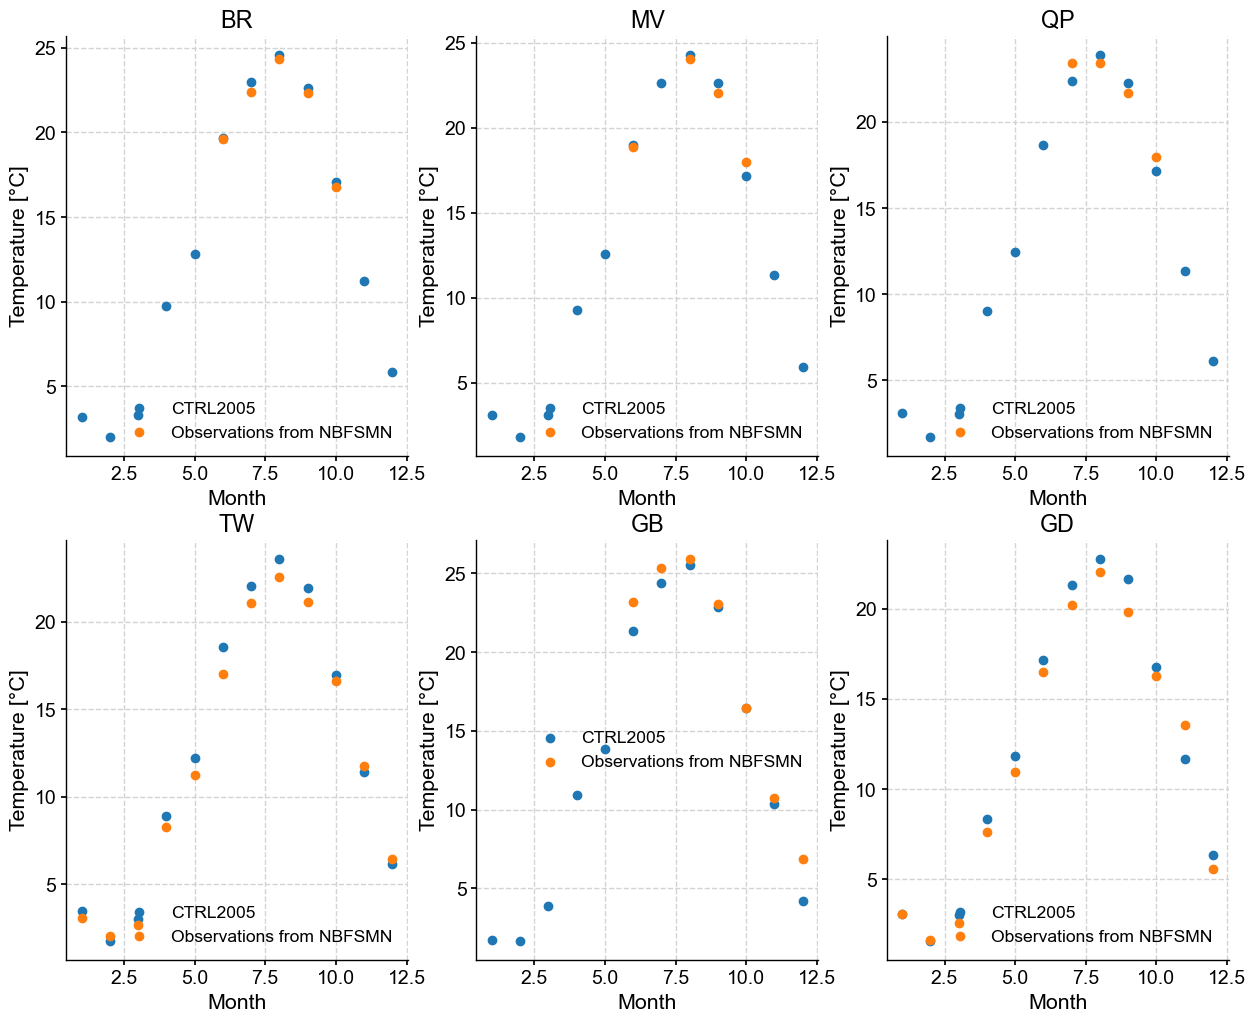

In [34]:
fig, axarr = plt.subplots(nrows = 2, ncols = 3, figsize = [15,12])
axarr = axarr.flatten()

for s, site in enumerate(ctrl2005['Site']):
    ax = axarr[s]
    ax.set_title(site.values)
    
    # SURFACE TEMPERATURE
    ds_here = ctrl2005.isel(Site = s, Depth = 0)
    # Model results
    x = ds_here['Month']
    y = ds_here['temp_mod']
    ax.scatter(x,y, label = 'CTRL2005')
    # Observations
    x = ds_here['Month']
    y = ds_here['temp_obs']
    ax.scatter(x,y, label = 'Observations from NBFSMN')
    
    ax.legend()
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature [°C]')

(0.0, 650.0)

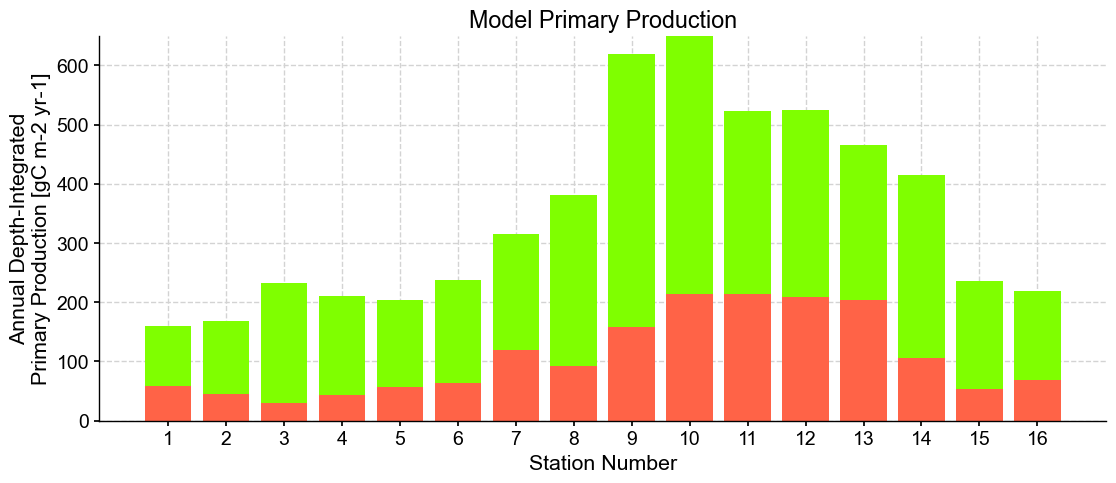

In [39]:
fig, ax = plt.subplots(figsize = [13,5])

cats = ctrl2005['Station']
vals = ctrl2005['PP_mod']
obs = ctrl2005['PP_obs']

ax.bar(cats, obs, color = 'chartreuse', label = 'CTRL2005')
ax.bar(cats, vals, color = 'tomato', label = ')

ax.legend()
ax.set_ylabel('Annual Depth-Integrated\nPrimary Production [gC m-2 yr-1]')
ax.set_xticks(cats)
ax.set_xlabel('Station Number')
ax.set_title('Model Primary Production')
ax.set_ylim([0,650])



In [35]:
ctrl2005

<xarray.Dataset>
Dimensions:      (Site: 6, Depth: 2, Month: 12, Station: 16, Parameters: 74)
Coordinates:
  * Site         (Site) object 'BR' 'MV' 'QP' 'TW' 'GB' 'GD'
  * Depth        (Depth) object 'Surface' 'Bottom'
  * Month        (Month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * Station      (Station) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * Parameters   (Parameters) object 'reg1' 'reg2' 'gmaxs1' ... 'bfp' 'bfs'
Data variables: (12/20)
    pH_obs       (Site, Depth, Month) float64 dask.array<chunksize=(6, 2, 12), meta=np.ndarray>
    pH_mod       (Site, Depth, Month) float64 dask.array<chunksize=(6, 2, 12), meta=np.ndarray>
    oxygen_obs   (Site, Depth, Month) float64 dask.array<chunksize=(6, 2, 12), meta=np.ndarray>
    oxygen_mod   (Site, Depth, Month) float64 dask.array<chunksize=(6, 2, 12), meta=np.ndarray>
    temp_obs     (Site, Depth, Month) float64 dask.array<chunksize=(6, 2, 12), meta=np.ndarray>
    temp_mod     (Site, Depth, Month) float64 dask.array<chunksize=(6, 2, 12), meta=np.ndarray>
    ...           ...
    NO3_cost     float64 ...
    pH_cost      (Depth) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    Si_cost      (Depth) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    oxygen_cost  (Depth) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    PP_cost      float64 ...
    param_vals   (Parameters) float64 dask.array<chunksize=(74,), meta=np.ndarray>
Attributes: (12/15)
    description:   CTRL 2005
    rundate:       25/6/2025
    year:          2005
    notes:         Primary production is strongly underestimated. I should in...
    BoundaryFile:  bry_osom_cosine_hab_monthly-nuts_grid5_mod11_10level_C_O_2...
    GridFile:      osom_grid5_mod11.nc
    ...            ...
    WindFile:      frc_NAM_wind_fields_OSOM_2005_ref-2005-01-01.nc
    SWradFile:     frc_bulk8_point_osom_2005_ref-2005-01-01_localswrad.nc
    NTIMES:        1576800
    nI:            498
    nJ:            548
    nZ:            10